In [35]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from time import time
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

## 1.      (1 балл) Выбрать и загрузить  датасет с помощью библиотеки Pandas. Датасет должен относиться к задаче классификации, содержать категориальные данные.

In [36]:
data = pd.read_csv('DATA.csv',sep=';')
data.head()

,student_id,age,sex,graduated_h_school_type,scholarship_type,additional_work,activity,partner,total_salary,transport,...,preparation_midterm_company,preparation_midterm_time,taking_notes,listenning,discussion_improves_interest,flip_classrom,grade_previous,grade_expected,course_id,grade
0,STUDENT1,2,2,3,3,1,2,2,1,1,...,1,1,3,2,1,2,1,1,1,1
1,STUDENT2,2,2,3,3,1,2,2,1,1,...,1,1,3,2,3,2,2,3,1,1
2,STUDENT3,2,2,2,3,2,2,2,2,4,...,1,1,2,2,1,1,2,2,1,1
3,STUDENT4,1,1,1,3,1,2,1,2,1,...,1,2,3,2,2,1,3,2,1,1
4,STUDENT5,2,2,1,3,2,2,1,3,1,...,2,1,2,2,2,1,2,2,1,1


Будем использовать датасет про студентов. Цель - предугадать оценку студента по его личной информации и отношении к учебе.

## Реализовать код, вносящий случайные искажения в данные.

In [37]:
for column in ['age', 'sex','graduated_h_school_type']:
    indices = np.random.choice(data.index, size=10, replace=False)
    data.loc[indices, column] = np.nan

In [38]:
data.head()

,student_id,age,sex,graduated_h_school_type,scholarship_type,additional_work,activity,partner,total_salary,transport,...,preparation_midterm_company,preparation_midterm_time,taking_notes,listenning,discussion_improves_interest,flip_classrom,grade_previous,grade_expected,course_id,grade
0,STUDENT1,2.0,2.0,3.0,3,1,2,2,1,1,...,1,1,3,2,1,2,1,1,1,1
1,STUDENT2,2.0,2.0,NaN,3,1,2,2,1,1,...,1,1,3,2,3,2,2,3,1,1
2,STUDENT3,2.0,2.0,2.0,3,2,2,2,2,4,...,1,1,2,2,1,1,2,2,1,1
3,STUDENT4,1.0,1.0,1.0,3,1,2,1,2,1,...,1,2,3,2,2,1,3,2,1,1
4,STUDENT5,2.0,2.0,1.0,3,2,2,1,3,1,...,2,1,2,2,2,1,2,2,1,1


## 2.      (1 балл) С помощью библиотеки Pandas произвести предварительный анализ датасета на наличие пропусков и искажений. Произвести исправление данных, используя 3 различные стратегии.

In [39]:
# давайте упростим систему оценивания с семибальной до пятибальной. Разница между 6 и 7 не так велика как между 4 и 5
data['grade'] = (data['grade']+1) // 2
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   student_id                    145 non-null    object 
 1   age                           135 non-null    float64
 2   sex                           135 non-null    float64
 3   graduated_h_school_type       135 non-null    float64
 4   scholarship_type              145 non-null    int64  
 5   additional_work               145 non-null    int64  
 6   activity                      145 non-null    int64  
 7   partner                       145 non-null    int64  
 8   total_salary                  145 non-null    int64  
 9   transport                     145 non-null    int64  
 10  accomodation                  145 non-null    int64  
 11  mother_ed                     145 non-null    int64  
 12  farther_ed                    145 non-null    int64  
 13  sibli

Сразу видно, что датасет приемлемых размеров, но не очень большой, всего 145 строк, однако стоит отметить, что данные имеют хорошее качество: нет NaN значений (помимо тех, что мы добавили), более того, судя по вопросам и возможным ответам в тесте, каждый столбец будет вносить примерно одинаковый вклад в итоговый результат (нет сильных перекосов между столбцами в плане абсолютных значений). 

Как очистить данные от NaN значений? 

Самый простой вариант - вырезать строки, в которых встречается хотя бы один NaN. Это хорошая тактика, ибо так мы оставим более достоверные данные в нашем датасете, но в этом случае так сделать не получится. Нам придется убрать от 10 до 30-ти строк, а с учетом того, что в датасете их всего 145, мы урежем и без того маленький набор данных. 

Применим более осторожный методы: заполнение средним и медианой, в нашем случае они не сильно отличаются друг от друга, но, тем не менее, помогут с неплохой точностью заполнить поля "пол" и "возраст"

С полем "graduated_h_school_type" все не так просто, поэтому тут лучше заполнить NaN значения нулями.

In [40]:
med = data['age'].median()
avg = data['sex'].mean()

data['age'] = data['age'].fillna(med)
data['sex'] = data['sex'].fillna(avg)
data['graduated_h_school_type'] = data['graduated_h_school_type'].fillna(0)

In [41]:
data['age'] = data['age'].astype(int)
data['sex'] = data['sex'].astype(int)
data['graduated_h_school_type'] = data['graduated_h_school_type'].astype(int)

## 4.      (1 балл) Произвести кодирование категориальных признаков. Применить one-hot-encoding. Произвести стандартизацию данных.

Нам очень повезло, целевой столбец уже находится в нужном нам виде (Label Encoding).
У нас имеется только один столбец, требующий правок - student_id. Но на нем лучше не использовать one-hot, ибо тогда просто создастся 145 дополнительных
столбцов, которые не принесут модели никакой полезной информации. 

В данном случае рациональнее будет его просто вырезать.

One-hot encoding в данном случае не нужен, ибо данные и так приведены в достаточно хороший вид, разбив признаки, мы только создадим больше столбцов, что не поможет модели обучиться


In [42]:
data = data.drop(columns = ['student_id'])
data.head()

,age,sex,graduated_h_school_type,scholarship_type,additional_work,activity,partner,total_salary,transport,accomodation,...,preparation_midterm_company,preparation_midterm_time,taking_notes,listenning,discussion_improves_interest,flip_classrom,grade_previous,grade_expected,course_id,grade
0,2,2,3,3,1,2,2,1,1,1,...,1,1,3,2,1,2,1,1,1,1
1,2,2,0,3,1,2,2,1,1,1,...,1,1,3,2,3,2,2,3,1,1
2,2,2,2,3,2,2,2,2,4,2,...,1,1,2,2,1,1,2,2,1,1
3,1,1,1,3,1,2,1,2,1,2,...,1,2,3,2,2,1,3,2,1,1
4,2,2,1,3,2,2,1,3,1,4,...,2,1,2,2,2,1,2,2,1,1


In [43]:
X = data
cols = X.columns
X = pd.DataFrame(StandardScaler().fit(X).transform(X), columns = cols)

## 5.      (2 балла) Разделить данные на обучающий и проверочный наборы. Решить задачу классификации, используя  библиотеку sklearn тремя способами (логистическая регрессия, метод опорных векторов, случайный лес), сравнить полученные результаты (метод score) для обучающих и проверочных данных. Сделать выводы.

In [55]:
y = data['grade'].values
X = data.drop(columns = ['grade'])

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15)

In [65]:
for a in [LogisticRegression(), SVC(),RandomForestClassifier()]:
    st = time()
    a.fit(X_train, y_train)
    print(f'Train score of {a} = {a.score(X_train, y_train)}')
    print(f'Test score of {a} = {a.score(X_test, y_test)}')
    print(f'Fit_predict time of {a} = {time() - st} seconds')


C:\Users\ilyas\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train score of LogisticRegression() = 0.8048780487804879
Test score of LogisticRegression() = 0.22727272727272727
Fit_predict time of LogisticRegression() = 0.03179645538330078 seconds
Train score of SVC() = 0.6666666666666666
Test score of SVC() = 0.4090909090909091
Fit_predict time of SVC() = 0.0158841609954834 seconds
Train score of RandomForestClassifier() = 1.0
Test score of RandomForestClassifier() = 0.5454545454545454
Fit_predict time of RandomForestClassifier() = 0.21575546264648438 seconds


In [49]:
b = LogisticRegression(penalty = 'l1', solver='liblinear', C = 0.1)
b.fit(X_train, y_train)
cf = b.coef_

X.columns[np.where(cf >0)[1]]

Index(['partner', 'total_salary', 'transport'], dtype='object')

In [18]:
sfs = SequentialFeatureSelector(LogisticRegression(), n_features_to_select=2, direction='forward')
sfs.fit(X_train, y_train)
selected_features = X.columns[sfs.get_support()]


selected_features

Index(['total_salary', 'grade_previous'], dtype='object')

In [19]:
tree = DecisionTreeClassifier(random_state=10)
tree.fit(X_train, y_train)
importances = tree.feature_importances_
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)[:5]

feature_importance

,Feature,Importance
30,course_id,0.172623
28,grade_previous,0.143961
6,partner,0.063451
12,siblings,0.062545
24,taking_notes,0.056171


Дерево отыскало интересную зависимость: направление обучения сильно влияет на оценки, а именно, на 9м курсе (можно посмотреть по датафрейму) наибольшее количество неудовлетворительных оценок, соответственно или там учатся очень слабые студенты или там преподают очень строгие учителя.

Еще вес имеет оценка, полученная за предыдущий семестр обучения, что тоже имеет смысл.

## 3.      (1 балл) С помощью библиотеки matplotlib построить графики исходных данных для каждой пары признаков (если набор данных позволяет это, в противном случае вернуться к этому пункту после уменьшения размерности в п.6).
Сделать выводы о зависимости признаков.

Давайте построим учтем 5 параматров: course_id, grade_previous, partner,siblings,taking_notes и grade

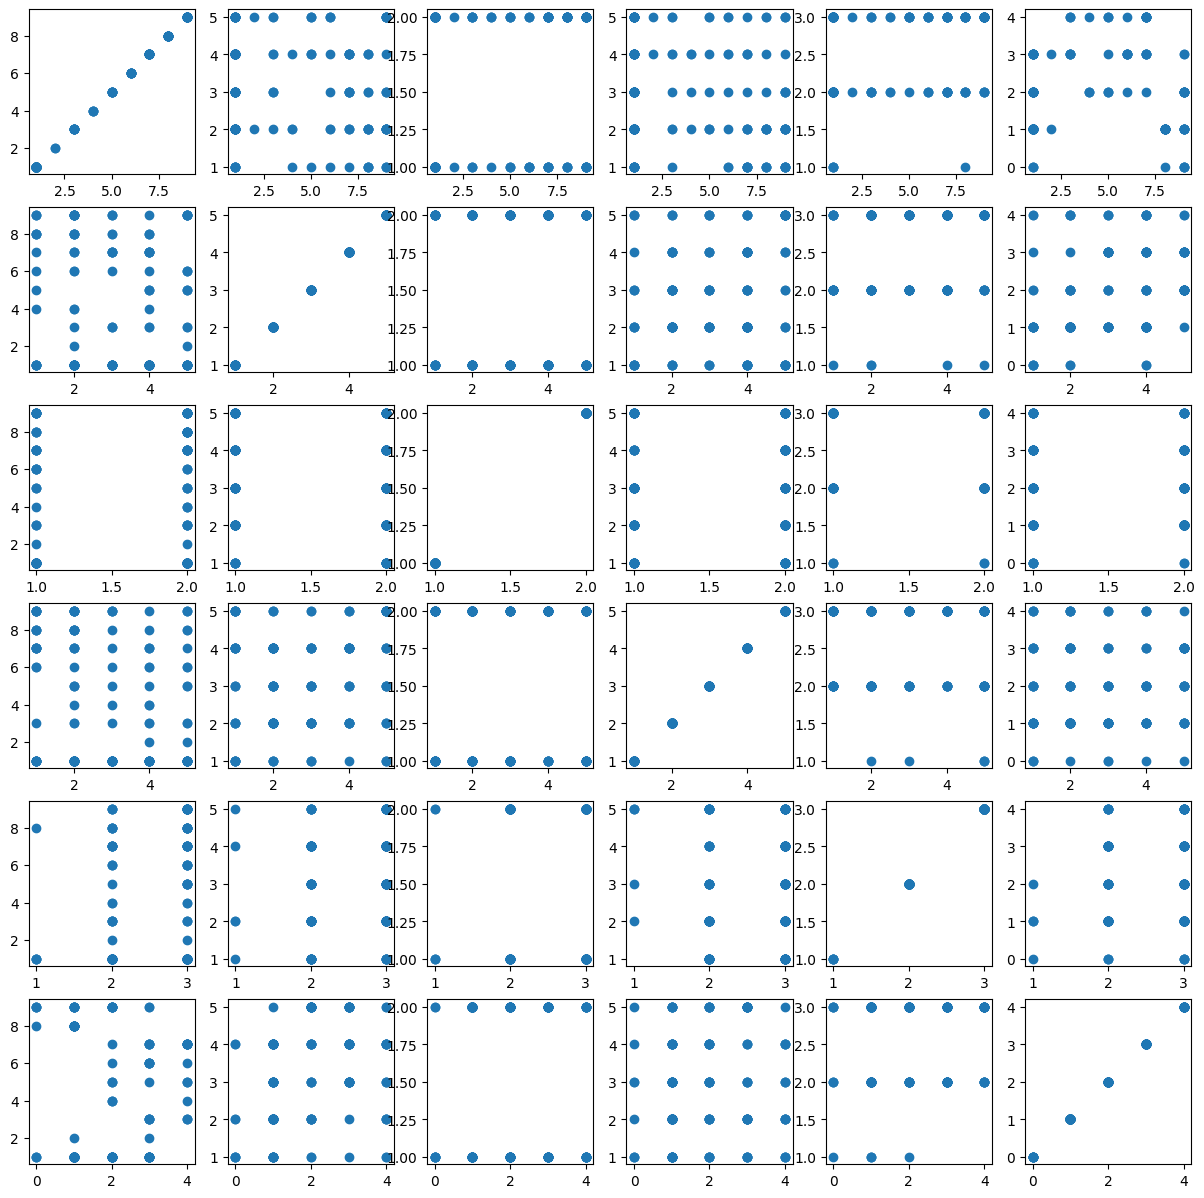

In [25]:
feats = ["course_id","grade_previous","partner","siblings","taking_notes","grade"]

new_X = data[feats]

fig, ax = plt.subplots(len(feats), len(feats), figsize =(15, 15))
for i in range(len(feats)):
    for j in range(len(feats)):
        ax[i,j].scatter(new_X[feats[i]], new_X[feats[j]])

Зависимостей в явном виде почти нет: единственное, что явно просматривается - зависимость между заметкми и номером курса. На некоторых курсах есть студенты, которые не делают записей на занятиях вообще, а на других их нет.

Зато видно, что первые два признака "course_id","grade_previous" некоторым образом влияют на grade, тогда как оставшиеся два распределены по графику равномерно. То есть, дерево не ошиблось: даже на примитивном графике видна некая связь между "course_id" и оценкой. 

## 3. ВЫВОДЫ

Чем можно обосновать score < 0.6? 

Проблема в том, что оценки зависят не только от тех факторов, которые перечислены в датасете. Часто ожидаемые оценки отличаются от реальных на порядок, так что первая сложность из-за которой получить высокий score нельзя - сама природа данных. 

Второй проблемой можно назвать многоклассовость данной классификациии. Отличить абсолютно провалившегося студента от хотя бы что-то знающего проще, чем отличить хорошиста от троечника. Переведя все оценки из восьмибальной системы в пятибальную ситуация стала немного лучше, но все равно, из-за обилия признаков, которые, зачастую, почти никак не зависят друг от друга сложно предсказывать четко, кто какую оценку получит.

В любом случае, все имеющиеся, пусть и не всегда ярко выраженные, зависимости модель отловила, так что её нельзя назвать бесполезной.